## CNN for Sentence Classification

Use Nal Kalchbrenner's Dynamic cnn for sentence classification

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import logging, csv, string, sys
import random
#need to use ccri fork of gensim
import gensim.models.word2vec as w2v
import gensim.models.doc2vec as d2v
import numpy as np
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
import os
#os.environ['THEANO_FLAGS'] = 'floatX=float32, device=cpu'
os.environ['THEANO_FLAGS'] = 'cuda.root=/usr/local/cuda-6.5,device=gpu,optimizer_including=cudnn,floatX=float32'
import theano.tensor as T
import dcnn
import sklearn.metrics as sklm
from tsne import bh_sne

Using gpu device 0: GeForce GTX 750 Ti


Sentences had been pre-parsed into dependency trees w/ parts of speech for use with another type of neural net

http://nlp.stanford.edu/~socherr/SocherKarpathyLeManningNg_TACL2013.pdf

This cnn ignores any of that pre-parsed sentence structure.

In [2]:
baseDir = "sentences_by_cat/"
# check out service/scripts/depParsing.scala to see how to make the files
files = os.listdir(baseDir)
files = [x for x in files if "parsed" in x]
def lineToList(line):
    if line != "":
        try:
            split = line.strip(")").split("(")
            tag = split[0]
            tupParts = split[1].split()
            parent = tupParts[0].split('-')[-1].strip('\,')
            childParts = tupParts[1].split("-")
            idx = childParts[-1]
            word = "-".encode("utf8").join(childParts[:-1])
            return [word, int(idx), int(parent), tag]
        except:
            print "failed on line " + line
            
def createTupleForFile(fn):
    f = open(baseDir + fn, "r")
    bigassString = f.read()
    f.close()
    return (fn, [map(lineToList, s.split("\n")) for s in bigassString.split("\n\n")])

In [3]:
grouped_by_file = dict([createTupleForFile(x) for x in files])
#errored on last line
grouped_by_file = dict([(x, y[:-1]) for x,y in grouped_by_file.iteritems()])

In [4]:
just_word_sentences = [map(lambda x: x[0], sentence) for f in grouped_by_file.values() for sentence in f]

In [5]:
tag_to_num = dict([(y,x) for x,y in enumerate(grouped_by_file.keys())])

In [6]:
labeled_sentences = [(tag_to_num.get(tag), sentence) for tag,lst in grouped_by_file.items() for sentence in lst]

Replace any numbers and punctuation with place-holder words.

In [7]:
def is_number(s):
    try:
        float(s)
        return True
    except ValueError:
        return False

def replaceWord(word):
    if all(char in string.punctuation for char in word):
        return "*PUNCT*".encode("utf8")
    elif is_number(word):
        return "*NUM*".encode("utf8")
    else:
        return word

def replaceStrangeWords(listOfWords):
    return map(replaceWord, listOfWords)

Start word vectors with pre trained word2vec vectors.
Not totally necessary but speeds things up.

In [8]:
sentences = map(replaceStrangeWords, just_word_sentences)
seededmodel = w2v.Word2Vec(initial = '/opt/devel/src/word2vec/vectors50.txt', size = 50, min_count=1)
seededmodel.build_vocab(sentences)
seededmodel.train(sentences)
seededmodel.train(sentences)
seededmodel.train(sentences)

81561

In [9]:
def getIndexForWord(word):
    if word in seededmodel.vocab:
        return seededmodel.vocab[word].index
    else:
        print 'couldnt find: ' + word
        return -1
    
lab_sen = [([getIndexForWord(replaceWord(tup[0])) for tup in sent if tup is not None], dcnn.one_of_n(t, 5)) for t,sent in labeled_sentences]

In [10]:
random.seed(5)
random.shuffle(lab_sen)
trainFrac = .7
validFrac = .1
t_frac = int(len(lab_sen) * trainFrac)
v_frac = int(len(lab_sen) * (trainFrac + validFrac))
train = lab_sen[:t_frac]
valid = lab_sen[t_frac:v_frac]
print seededmodel.syn0.shape
voc_with_zero_vec = np.vstack((seededmodel.syn0, np.zeros(50)))
print voc_with_zero_vec.shape

(4419, 50)
(4420, 50)


Training on 70% of the data. validating on 10% and saving the other 20% to test on.

In [11]:
nn = dcnn.DCNN(voc_with_zero_vec, [0,0,1], [5,3,5], [5,3,2], train, valid, k_top=3, hidden_dim=100)

/opt/devel/w2vEnv/venv/local/lib/python2.7/site-packages/theano/scan_module/scan_perform_ext.py:133: RuntimeWarning: numpy.ndarray size changed, may indicate binary incompatibility
  from scan_perform.scan_perform import *


In [12]:
# prev = nn.theta.get_value()
# prevh = nn.hidden_layer.get_value()
nn.train_cross_ent(20,5)
# print prev - nn.theta.get_value()
# print prevh - nn.hidden_layer.get_value()

Running epoch 0
F1 score for this epoch:
0.570637173148
epoch 0 completed in 10.14 (sec)
Running epoch 1
F1 score for this epoch:
0.657203692163
epoch 1 completed in 10.10 (sec)
Running epoch 2
F1 score for this epoch:
0.709719715422
epoch 2 completed in 10.07 (sec)
Running epoch 3
F1 score for this epoch:
0.740661887132
epoch 3 completed in 10.17 (sec)
Running epoch 4
F1 score for this epoch:
0.74111609857
epoch 4 completed in 10.18 (sec)
Running epoch 5
F1 score for this epoch:
0.768289632434
epoch 5 completed in 10.44 (sec)
Running epoch 6
F1 score for this epoch:
0.793896102357
epoch 6 completed in 10.36 (sec)
Running epoch 7
F1 score for this epoch:
0.812533873189
epoch 7 completed in 10.29 (sec)
Running epoch 8
F1 score for this epoch:
0.831110551569
epoch 8 completed in 10.19 (sec)
Running epoch 9
F1 score for this epoch:
0.812061767247
epoch 9 completed in 9.97 (sec)
Running epoch 10
F1 score for this epoch:
0.808235377769
epoch 10 completed in 10.12 (sec)
Running epoch 11
F1 s

/opt/devel/w2vEnv/venv/local/lib/python2.7/site-packages/sklearn/metrics/metrics.py:1771: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Train for a few epochs using the bootstrap-soft objective function after primary training completed.

In [13]:
nn.train_multi_b_soft(.9, 3, 5)

Running epoch 0
F1 score for this epoch:
0.814968449966
epoch 0 completed in 10.59 (sec)
Running epoch 1
F1 score for this epoch:
0.821895340332
epoch 1 completed in 10.57 (sec)
Running epoch 2
F1 score for this epoch:
0.813496603749
epoch 2 completed in 10.63 (sec)


In [14]:
testX = map(lambda x: x[0], lab_sen[v_frac:])
testY = map(lambda x: np.argmax(x[1]), lab_sen[v_frac:])

In [15]:
preds = np.array(nn.predict(testX))

Look at the F1 scores and accuracy as well as the confusion matrix.

In [16]:
singleX = map(np.argmax, preds)
print len(preds)
print sklm.f1_score(testY, singleX, average='macro')
print sklm.f1_score(testY, singleX, average='micro')
print sklm.accuracy_score(testY, singleX)
print tag_to_num
conf =  sklm.confusion_matrix(testY, singleX)
print conf
print np.sum(conf, axis=1) / (np.sum(conf) * 1.0)

624
0.639575115781
0.826923076923
0.826923076923
{'AIMX-parsed.txt': 0, 'BASE-parsed.txt': 1, 'MISC-parsed.txt': 2, 'OWNX-parsed.txt': 3, 'CONT-parsed.txt': 4}
[[ 37   0   2  10   1]
 [  0   2   4   6   1]
 [  0   0 324  25  15]
 [  8   2  17 136   0]
 [  0   0  11   6  17]]
[ 0.08012821  0.02083333  0.58333333  0.26121795  0.05448718]


In [17]:
allX = map(lambda x: x[0], lab_sen)
allY = map(lambda x: np.argmax(x[1]), lab_sen)
allpreds = np.array(nn.predict(allX))
allembeds = np.array(nn.embed(allX))

In [34]:
all_single_X = map(np.argmax, allpreds)
print len(allpreds)
print sklm.f1_score(allY, all_single_X, average='macro')
print sklm.f1_score(allY, all_single_X, average='micro')
print sklm.accuracy_score(allY, all_single_X)
print tag_to_num
conf_all =  sklm.confusion_matrix(allY, all_single_X)
print conf_all
print np.sum(conf_all, axis=1) / (np.sum(conf_all) * 1.0)

3117
0.809875411765
0.906961822265
0.906961822265
{'AIMX-parsed.txt': 0, 'BASE-parsed.txt': 1, 'MISC-parsed.txt': 2, 'OWNX-parsed.txt': 3, 'CONT-parsed.txt': 4}
[[ 161    0    4   28    1]
 [   2   36    7   15    1]
 [   3    2 1733   57   30]
 [  21    7   51  788    0]
 [   0    2   45   14  109]]
[ 0.06223933  0.0195701   0.58549888  0.27815207  0.05453962]


In [19]:
reduced = bh_sne(np.array(allembeds, dtype='float64'))

Look at the embeddings from the fully connected layer before the softmax.

First colored by their ground true classfication.

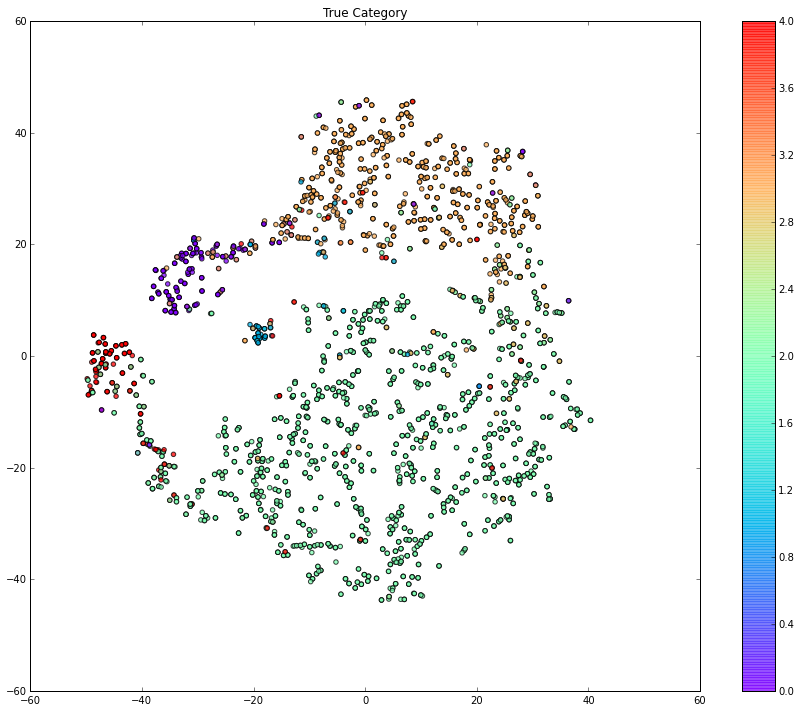

In [42]:
plt.figure(figsize=(15,12))
plt.scatter(reduced[:, 0], reduced[:, 1], c=allY, cmap=plt.cm.rainbow, alpha=.75)
plt.colorbar()
plt.title("True Category")
plt.savefig("true_embed.png")

Then colored by the predicted classification.

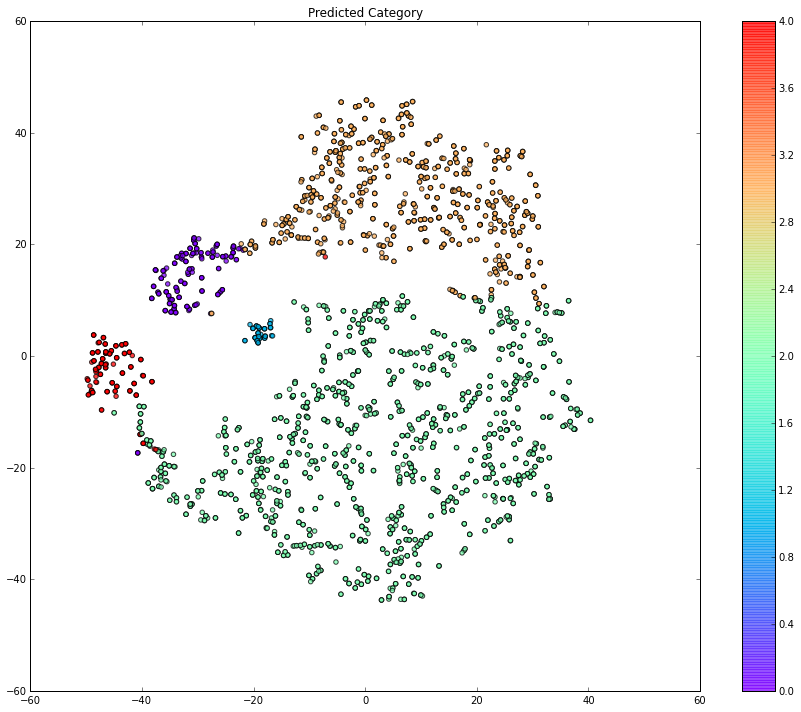

In [41]:
plt.figure(figsize=(15,12))
plt.scatter(reduced[:, 0], reduced[:, 1], c=map(np.argmax, allpreds), cmap=plt.cm.rainbow, alpha=.75)
plt.colorbar()
plt.title("Predicted Category")
plt.savefig("predicted_embed.png")

### Compare to Doc2Vec with Logistic Regression classification

We do a similar run with Doc2Vec training logistic regression on 70%.

It still does better than the methods from the original paper but not as well as the CNN

In [26]:
docsentences = [(d2v.LabeledSentence(replaceStrangeWords([x[0] for x in s[1]]),['id-'+str(i)]), s[0]) for i,s in enumerate(labeled_sentences) ]

In [27]:
print docsentences[0][0]
d2vmodel = d2v.Doc2Vec(initial = '/opt/devel/src/word2vec/vectors50.txt', size = 50, min_count=1)
d2vmodel.build_vocab([x[0] for x in docsentences])
d2vmodel.train([x[0] for x in docsentences])
random.shuffle(docsentences)
d2vmodel.train([x[0] for x in docsentences])
random.shuffle(docsentences)
d2vmodel.train([x[0] for x in docsentences])

LabeledSentence(['In', 'the', 'first', 'part', 'of', 'the', 'paper', 'we', 'use', 'the', 'Hadamard', 'matrix', 'to', 'construct', 'a', 'regularized', 'risk', 'minimization', 'problem', 'and', 'show', 'that', 'these', 'rates', 'can', 'not', 'be', 'improved'], ['id-0'])


84678

In [28]:
vecs = [(d2vmodel[x.labels[0]], y)for x,y in docsentences]
random.seed(5)
random.shuffle(vecs)
lr_train = vecs[:t_frac]

In [32]:
from sklearn import linear_model
logreg = linear_model.LogisticRegression(C=1e5)
X, y = zip(*lr_train)
logreg.fit(X,y)
lr_testX, lr_testY = zip(*vecs)
lr_preds = logreg.predict(lr_testX)

In [33]:
print len(lr_preds)
print sklm.f1_score(lr_testY, lr_preds, average='macro')
print sklm.f1_score(lr_testY, lr_preds, average='micro')
print sklm.accuracy_score(lr_testY, lr_preds)
print tag_to_num
print sklm.confusion_matrix(lr_testY, lr_preds)

3117
0.3427146362
0.67468719923
0.67468719923
{'AIMX-parsed.txt': 0, 'BASE-parsed.txt': 1, 'MISC-parsed.txt': 2, 'OWNX-parsed.txt': 3, 'CONT-parsed.txt': 4}
[[  19    0  112   63    0]
 [   1    6   38   15    1]
 [   6    2 1636  178    3]
 [  11    1  416  438    1]
 [   0    1  126   39    4]]


In [35]:
d2v_reduced = bh_sne(np.array(map(lambda x: x[0], vecs), dtype='float64'))

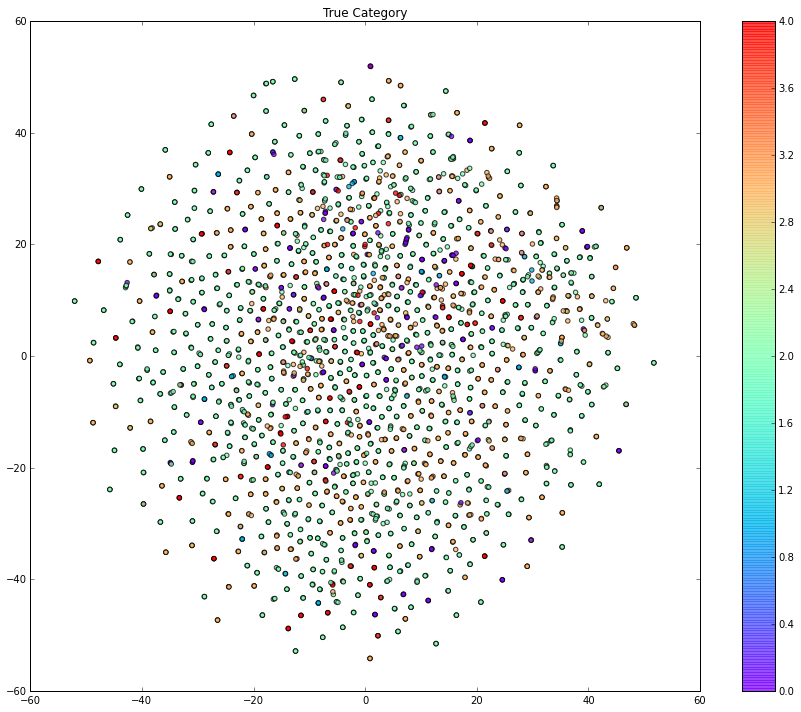

In [39]:
plt.figure(figsize=(15,12))
plt.scatter(d2v_reduced[:, 0], d2v_reduced[:, 1], c=lr_testY, cmap=plt.cm.rainbow, alpha=.75)
plt.colorbar()
plt.title("True Category")
plt.savefig("true_embed_d2v.png")

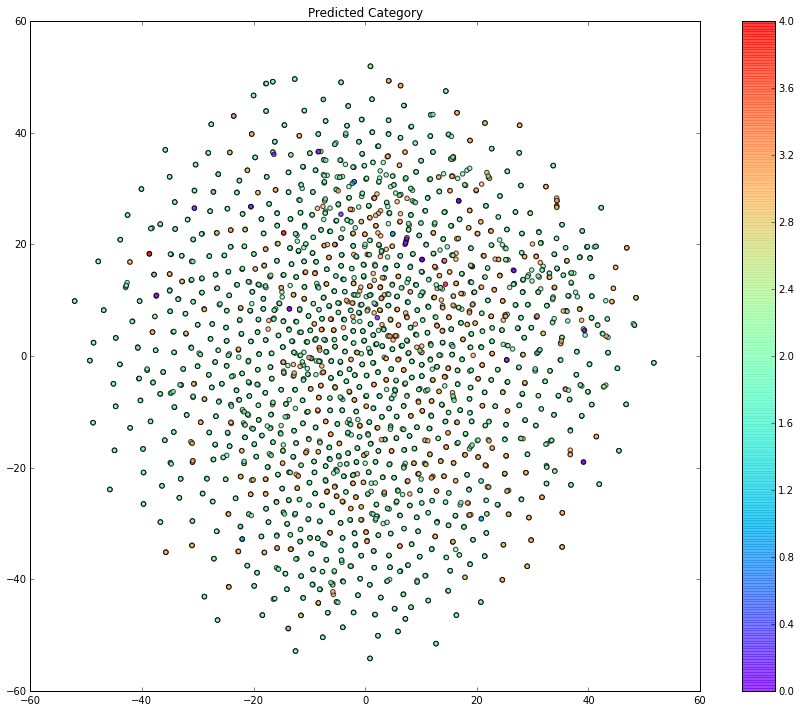

In [40]:
plt.figure(figsize=(15,12))
plt.scatter(d2v_reduced[:, 0], d2v_reduced[:, 1], c=lr_preds, cmap=plt.cm.rainbow, alpha=.75)
plt.colorbar()
plt.title("Predicted Category")
plt.savefig("predicted_embed_d2v.png")